In [ ]:
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import plot_model,to_categorical
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spec_path = '/content/drive/MyDrive/thesis/features/spectrograms/'
mfcc_path = '/content/drive/MyDrive/thesis/features/mfcc/'
label_path = '/content/drive/MyDrive/thesis/features/labels/'

In [ ]:
spec_files =sorted(glob(spec_path+'*.npy'))
mfcc_files = sorted(glob(mfcc_path+'*.npy'))
label_files = sorted(glob(label_path+'*.npy'))

In [ ]:
def load_data(path):
    lst = listdir(path)
    x = []
    for i in tqdm.tqdm(range(len(lst))):
        x.append(np.load(path+lst[i]))
    return x

In [ ]:
spec_dataset = load_data(spec_path)

100%|██████████| 909/909 [00:43<00:00, 20.84it/s] 


In [ ]:
# mfcc_dataset = load_data(mfcc_path)

In [ ]:
label_dataset = load_data(label_path)

100%|██████████| 909/909 [00:17<00:00, 51.96it/s] 


In [ ]:
def encode_labels(dis_list):
    le = preprocessing.LabelEncoder()
    le.fit(dis_list)
    dis_list_idx = le.transform(dis_list)
    return dis_list_idx

In [ ]:
gt_cat = encode_labels(label_dataset)

In [ ]:
for i in range(8):
  print(np.where(gt_cat==i)[0].shape)

(1,)
(16,)
(13,)
(782,)
(35,)
(2,)
(37,)
(23,)


In [ ]:
np.where(gt_cat==5)[0]

array([41, 68])

(array([ 17.,  13., 782.,  35.,   2.,  60.]),
 array([0.        , 1.16666667, 2.33333333, 3.5       , 4.66666667,
        5.83333333, 7.        ]),
 <a list of 6 Patch objects>)

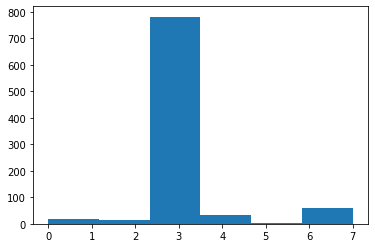

In [ ]:
plt.hist(gt_cat, bins=6)

In [ ]:
spec_dataset = np.delete(spec_dataset, np.where((gt_cat == 0) | (gt_cat == 5))[0], axis=0)
# mfcc_dataset = np.delete(mfcc_dataset, np.where((gt_cat == 0) | (gt_cat == 5))[0], axis=0)
gt_cat = np.delete(gt_cat, np.where((gt_cat == 0) | (gt_cat == 5))[0], axis=0)

In [ ]:
for i in range(8):
  print(np.where(gt_cat==i)[0].shape)

(0,)
(16,)
(13,)
(782,)
(35,)
(0,)
(37,)
(23,)


In [ ]:
# spec_dataset.shape, mfcc_dataset.shape, gt_cat.shape

In [ ]:
import pandas as pd
s = pd.Series(list(gt_cat))
gt_list = pd.get_dummies(s)

In [ ]:
gt_list = np.array((np.asarray(gt_list)))

In [ ]:
# gt_list = to_categorical(gt_cat, num_classes = 6)

In [ ]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(spec_dataset, gt_list, test_size=0.20, shuffle= True)

In [ ]:
np.shape(x_train)

(724, 257, 646)

In [ ]:
# def normalizeXX(eg_array):
#     normed = (eg_array - eg_array.mean(axis=0)) / eg_array.std(axis=0)
#     return normed

In [ ]:
epochs = 50
num_classes = 6
batches = 64

In [ ]:
# y_train = np.expand_dims(y_train, axis = 0)
# y_test = np.expand_dims(y_test, axis = 0)

In [ ]:
visible = Input(shape=(257, 646,1))
conv1 = Conv2D(16, kernel_size=(3,3), padding = 'same')(visible)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 1))(conv1)
conv2 = Conv2D(32, kernel_size=(3,3), activation='relu', padding = 'same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 1))(conv2)

pool3 = Flatten()(pool2)

# pool3 = Dense(64, activation='relu')(pool3)
output = Dense(num_classes, activation='softmax')(pool3)
model = Model(inputs=visible, outputs=output)


print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 646, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 257, 646, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 257, 646, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 257, 646, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 646, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 646, 32)      4640  

In [ ]:
y_train[0]

array([0, 0, 1, 0, 0, 0], dtype=uint8)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=model.fit(x=tf.convert_to_tensor(np.float32(x_train)), y=tf.convert_to_tensor(np.float32(y_train)), validation_split = 0.10, batch_size=batches, epochs=epochs)

Epoch 1/50
11/11 [==============================] - 15s 378ms/step - loss: 86.9231 - accuracy: 0.7419 - val_loss: 2053.6545 - val_accuracy: 0.9041
Epoch 2/50
11/11 [==============================] - 3s 291ms/step - loss: 42.3434 - accuracy: 0.7926 - val_loss: 1949.1168 - val_accuracy: 0.9041
Epoch 3/50
11/11 [==============================] - 3s 290ms/step - loss: 22.8978 - accuracy: 0.8556 - val_loss: 1326.4293 - val_accuracy: 0.9041
Epoch 4/50
11/11 [==============================] - 3s 289ms/step - loss: 11.3607 - accuracy: 0.8909 - val_loss: 1076.4664 - val_accuracy: 0.9041
Epoch 5/50
11/11 [==============================] - 3s 291ms/step - loss: 6.8785 - accuracy: 0.8971 - val_loss: 917.8400 - val_accuracy: 0.9041
Epoch 6/50
11/11 [==============================] - 3s 292ms/step - loss: 2.4855 - accuracy: 0.9585 - val_loss: 797.1000 - val_accuracy: 0.9041
Epoch 7/50
11/11 [==============================] - 3s 292ms/step - loss: 1.3282 - accuracy: 0.9647 - val_loss: 649.9518 - val_

In [ ]:
x_test.shape, y_test.shape

((182, 257, 646), (182, 6))

Accuracy: 81%
Loss: 22.0292



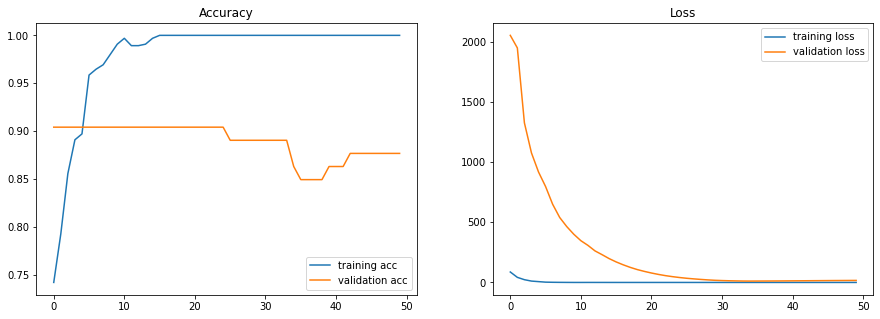

In [ ]:
score = model.evaluate(np.float32(x_test), np.float32(y_test), verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(np.float32(x_test), verbose=1)
y_pred_bool = np.argmax(np.float32(y_pred), axis=1)

print(classification_report(np.argmax(np.float32(y_test),axis=1), y_pred_bool))

6/6 [==============================] - 0s 41ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         3
           2       0.86      0.96      0.91       152
           3       0.00      0.00      0.00        10
           4       0.50      0.50      0.50         4
           5       0.00      0.00      0.00         7

    accuracy                           0.81       182
   macro avg       0.23      0.24      0.23       182
weighted avg       0.73      0.81      0.77       182



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
